# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import (IntegerType, StringType, DoubleType, DateType)
from pyspark.sql.window import Window
import numpy as np
import pandas as pd 
#for visualizing
import matplotlib.pyplot as plt 
import seaborn as sb
import datetime
from pyspark.sql.functions import col,sum
from pyspark.sql.functions import dayofmonth, hour, dayofyear, month, year, weekofyear

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
# create a Spark session
spark = SparkSession.Builder().appName("capstone").getOrCreate()

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [12]:
df.count()

286500

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [16]:
# Possible events for users
df.groupby('page').count().orderBy('count', ascending=False).show(25)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



#### #Remove records with empty userId

In [4]:
df = df[df['userId'] != '']

In [38]:
df.count()

278154

#### #Count the missing values

In [41]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# Have a clear time
get_time = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('time', get_time(df.ts))
#df.select(['firstName', 'gender', 'level', 'page', 'song', 'artist', 'time']).filter('firstName == "Colin"').sample(0.5).show()

In [6]:
df.select(df.time).show(1)

+-------------------+
|               time|
+-------------------+
|10-01-2018 00:01:57|
+-------------------+
only showing top 1 row



In [5]:
#Add an hour column
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
df = df.withColumn('hour', get_hour(df.ts))

In [6]:
#Add a weekday column
get_weekday = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%w"))
df = df.withColumn('weekday', get_weekday(df.ts))

In [9]:
# Add churn column
churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', churn(df.page))

#### Event Distribution

Text(0,0.5,'events')

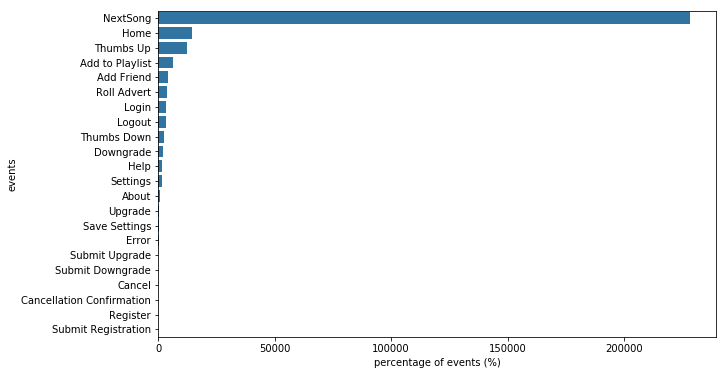

In [93]:
events_pandas_df = df.groupby('page').count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(10,6))
sb.barplot(y=events_pandas_df.page, x=events_pandas_df['count'], color=sb.color_palette()[0])
plt.xlabel('percentage of events (%)')
plt.ylabel('events')
plt.title('Event Distribution');

#### Analysis on churned cutomers

In [11]:
churn_df = df.filter('churn == 1')

Text(0.5,1,'gender churn distribution')

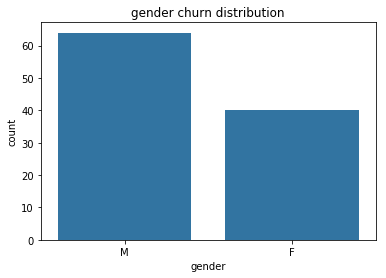

In [128]:
# gender churn distribution
gender_churn_df = churn_df.groupby(['gender']).count().orderBy('count', ascending=False).toPandas()
#plt.figure(figsize=(10,6))
sb.barplot(y=gender_churn_df['count'], x=gender_churn_df['gender'], color=sb.color_palette()[0]);
plt.title('gender churn distribution');

Text(0.5,1,'Subscribtion level for churned customers distribution')

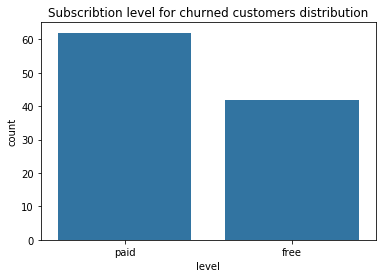

In [127]:
# Subscribtion level for churned customers distribution
level_churn_df = churn_df.groupby(['level']).count().orderBy('count', ascending=False).toPandas()
sb.barplot(y=level_churn_df['count'], x=level_churn_df['level'], color=sb.color_palette()[0]);
plt.title('Subscribtion level for churned customers distribution');

In [159]:
churn_df.groupby(['weekday']).count().orderBy('count', ascending=False).show()

+-------+-----+
|weekday|count|
+-------+-----+
|      5|   26|
|      1|   18|
|      6|   15|
|      3|   14|
|      2|   12|
|      4|   10|
|      0|    9|
+-------+-----+



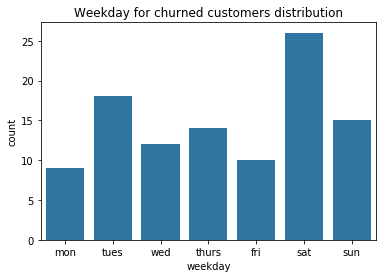

In [162]:
# Weekday for churned customers distribution
week_churn_df = churn_df.groupby(['weekday']).count().orderBy('count', ascending=False).toPandas()
sb.barplot(y=week_churn_df['count'], x=week_churn_df['weekday'], color=sb.color_palette()[0]);
plt.title('Weekday for churned customers distribution');
plt.xticks([0,1,2,3,4,5,6], ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']);

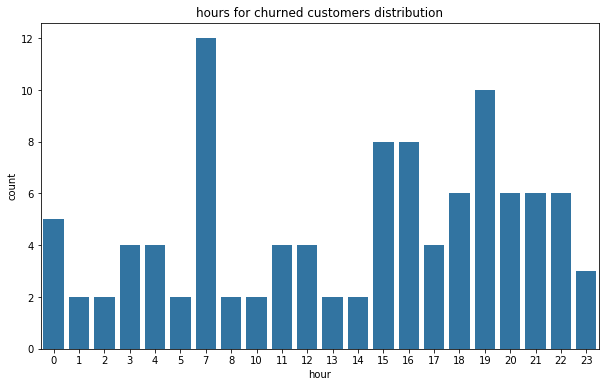

In [186]:
# hours for churned customers distribution
hour_churn_df = churn_df.groupby(['hour']).count().orderBy('count', ascending=False).toPandas()
hour_churn_df.hour = hour_churn_df.hour.astype('int64')
hour_churn_df.sort_values(by = 'hour', ascending=True,inplace = True)
plt.figure(figsize=(10,6))
sb.barplot(y=hour_churn_df['count'], x=hour_churn_df['hour'], color=sb.color_palette()[0]);
plt.title('hours for churned customers distribution');

In [182]:
# Location of most churned customers
churn_df.groupby(['location']).count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|            location|count|
+--------------------+-----+
|New York-Newark-J...|   10|
|Los Angeles-Long ...|    6|
|Spokane-Spokane V...|    4|
|         Jackson, MS|    4|
|Philadelphia-Camd...|    4|
|Phoenix-Mesa-Scot...|    4|
|Miami-Fort Lauder...|    4|
|           Flint, MI|    4|
|Indianapolis-Carm...|    2|
|Birmingham-Hoover...|    2|
+--------------------+-----+
only showing top 10 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
# Add gender feature
gender = df.select('userId', 'gender').dropDuplicates(subset=['userId']).\
replace(['F', 'M'], ['0', '1'], 'gender').select('userId', F.col('gender').cast('int'))


In [11]:
# Add Subscription feature
subscription = df.select('userId', 'level').dropDuplicates(subset=['userId']).\
replace(['free', 'paid'], ['0', '1'], 'level').select('userId', F.col('level').cast('int'))

In [12]:
# Time Spent listening feature
time_spent = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'time_spent')

In [13]:
# Number of friends added
friends = df.select('userID','page').filter('page == "Add Friend"')\
.groupBy('userID').count().withColumnRenamed('count', 'added_friends')

In [14]:
#Number of playlist songs
playlists = df.select('userID','page').filter('page == "Add to Playlist"')\
.groupBy('userID').count().withColumnRenamed('count', 'songs_playlisted')

In [15]:
# Number of help requests
help_req = df.select('userID','page').filter('page == "Help"')\
.groupBy('userID').count().withColumnRenamed('count', 'help_requests')

In [16]:
# Add downgraded column
is_downgraded = F.udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df = df.withColumn('is_downgraded', is_downgraded(df.page))

#Add downgraded feature
# Note the sorting part here to ensure if a customer made submit downgrade
# he is not removed dute to drop duplicates
downgraded = df.select('userId', 'is_downgraded').sort('is_downgraded', ascending=False).dropDuplicates(subset=['userId'])

In [17]:
# Add churn label
churn = df.select('userId', 'churn').sort('churn', ascending=False).dropDuplicates(subset=['userId'])

In [18]:
# Join features and labels into new dataframe

new_df = gender.join(subscription, on='userId', how='outer')\
               .join(time_spent, on='userId', how='outer')\
               .join(friends, on='userId', how='outer')\
               .join(playlists, on='userId', how='outer')\
               .join(help_req, on='userId', how='outer')\
               .join(downgraded, on='userId', how='outer')\
               .join(churn, on='userId', how='outer')\
               .fillna(0)

In [105]:
#check size of data
new_df.count()

225

In [106]:
# check data types
new_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- sum(length): double (nullable = false)
 |-- added_friends: long (nullable = true)
 |-- songs_playlisted: long (nullable = true)
 |-- help_requests: long (nullable = true)
 |-- is_downgraded: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [19]:
# Check dataframe
new_df.show(5)

+------+------+-----+------------------+-------------+----------------+-------------+-------------+-----+
|userId|gender|level|        time_spent|added_friends|songs_playlisted|help_requests|is_downgraded|churn|
+------+------+-----+------------------+-------------+----------------+-------------+-------------+-----+
|100010|     0|    0| 66940.89735000003|            4|               7|            2|            0|    0|
|200002|     1|    0| 94008.87593999993|            4|               8|            2|            0|    0|
|   125|     1|    0|2089.1131000000005|            0|               0|            0|            0|    1|
|   124|     0|    1|1012312.0927899999|           74|             118|           23|            0|    0|
|    51|     1|    1| 523275.8428000004|           28|              52|           12|            0|    1|
+------+------+-----+------------------+-------------+----------------+-------------+-------------+-----+
only showing top 5 rows



In [20]:
# Check if label is balalnced or not
new_df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



we can see that data is imbalanced therefore an upsampling approach or SMOTE can be used

In [113]:
# Check missing Values
from pyspark.sql.functions import col,sum
new_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in new_df.columns)).show()

+------+------+-----+----------+-------------+----------------+-------------+-------------+-----+
|userId|gender|level|time_spent|added_friends|songs_playlisted|help_requests|is_downgraded|churn|
+------+------+-----+----------+-------------+----------------+-------------+-------------+-----+
|     0|     0|    0|         0|            0|               0|            0|            0|    0|
+------+------+-----+----------+-------------+----------------+-------------+-------------+-----+



In [22]:
new_df.columns

['userId',
 'gender',
 'level',
 'time_spent',
 'added_friends',
 'songs_playlisted',
 'help_requests',
 'is_downgraded',
 'churn']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [42]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [23]:
# Change features into a dense vector
df_assembler = VectorAssembler(inputCols=['gender','level','time_spent','added_friends',
                                         'songs_playlisted','help_requests','is_downgraded'],
                              outputCol="features")
new_df = df_assembler.transform(new_df)

In [38]:
# Final DF
final_df = new_df.select('features', 'churn')
final_df = final_df.withColumnRenamed('churn', 'label')
final_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,66940.89...|    0|
|[1.0,0.0,94008.87...|    0|
|(7,[0,2],[1.0,208...|    1|
+--------------------+-----+
only showing top 3 rows



In [39]:
#Split the Data into Train and Test Datasets
train, test = final_df.randomSplit([0.75, 0.25], seed=0)

#### Build and Train the Logistic Regression Model

In [40]:
# Build and Train the Logistic Regression Model
lr = LogisticRegression()
lr_model = lr.fit(train)

In [41]:
# Evaluate Performance on Training Data
lr_summary = lr_model.summary
print('Accuracy: {}'.format(lr_summary.accuracy))
print('AUC: {}'.format(lr_summary.areaUnderROC))
print('recall: {}'.format(lr_summary.weightedRecall))
print('Precision: {}'.format(lr_summary.weightedPrecision))`

Accuracy: 0.7425149700598802
AUC: 0.6567891972993248
recall: 0.7425149700598802
Precision: 0.5513284807630249


In [53]:
#Evaluate Performance on Test Data
lr_model_predictions = lr_model.transform(test)

lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(lr_model_predictions)
print(f'The auc value of Logistic Regression Model is {lr_auroc}')

lr_evaluator = MulticlassClassificationEvaluator()
lr_f1 = lr_evaluator.evaluate(lr_model_predictions,{lr_evaluator.metricName: "f1"})
print(f'The F1-Score value of Logistic Regression Model is {lr_f1}')

The auc value of Logistic Regression Model is0.4988662131519274
The F1-Score value of Logistic Regression Model is0.7737673219465033


#### Build and Train the Random Forest Model

In [59]:
#Build and Train the Random Forest Model
rf = RandomForestClassifier()
rf_model = rf.fit(train)

#Evaluate Performance on Test Data
rf_model_predictions = rf_model.transform(test)

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(rf_model_predictions)
print(f'The auc value of RandomForestClassifier Model is {rf_auroc}')

rf_evaluator = MulticlassClassificationEvaluator(metricName='f1')
rf_f1 = lr_evaluator.evaluate(rf_model_predictions)
print(f'The F1-Score value of RandomForestClassifier Model is {rf_f1}')

The auc value of RandomForestClassifier Model is 0.5782312925170069
The F1-Score value of RandomForestClassifier Model is 0.7563218390804597


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.